# Imports

In [1]:
try:
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN
    print("Library is already installed.")
except ImportError:
    print("Library is not installed. Proceed with installation.")
    !pip install fancyimpute
    from fancyimpute import IterativeSVD
    from fancyimpute import KNN

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import re

Library is already installed.


### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/sample_submission.csv'))
df_data: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e15/data.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv'), index_col='id')

In [4]:
df_data.isna().sum()

author                  5024
geometry                5500
pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
dtype: int64

In [5]:
df_og.isna().sum()

author                 0
geometry               0
pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
dtype: int64

##### Our training data contains lots of missing values, we could impute them using a very simple strategy like mean or median however this will likely result is poor model quality due to the about of missing value. Instead, we can also predict what value the missing value should have based off the other non-null value in these columns. The original data could be very he puff for that purpose since it does not contain any missing values.

In [6]:
df_sample_submission.head()

,id,x_e_out [-]
0,4,0.0
1,7,0.0
2,10,0.0
3,12,0.0
4,23,0.0


##### As describe in the completions we are prediction the missing values for x_e_out, our test data consist of all the row with missing x_e_out.

In [7]:
df_data.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [8]:
df_og.head()

,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
id,,,,,,,,,
1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


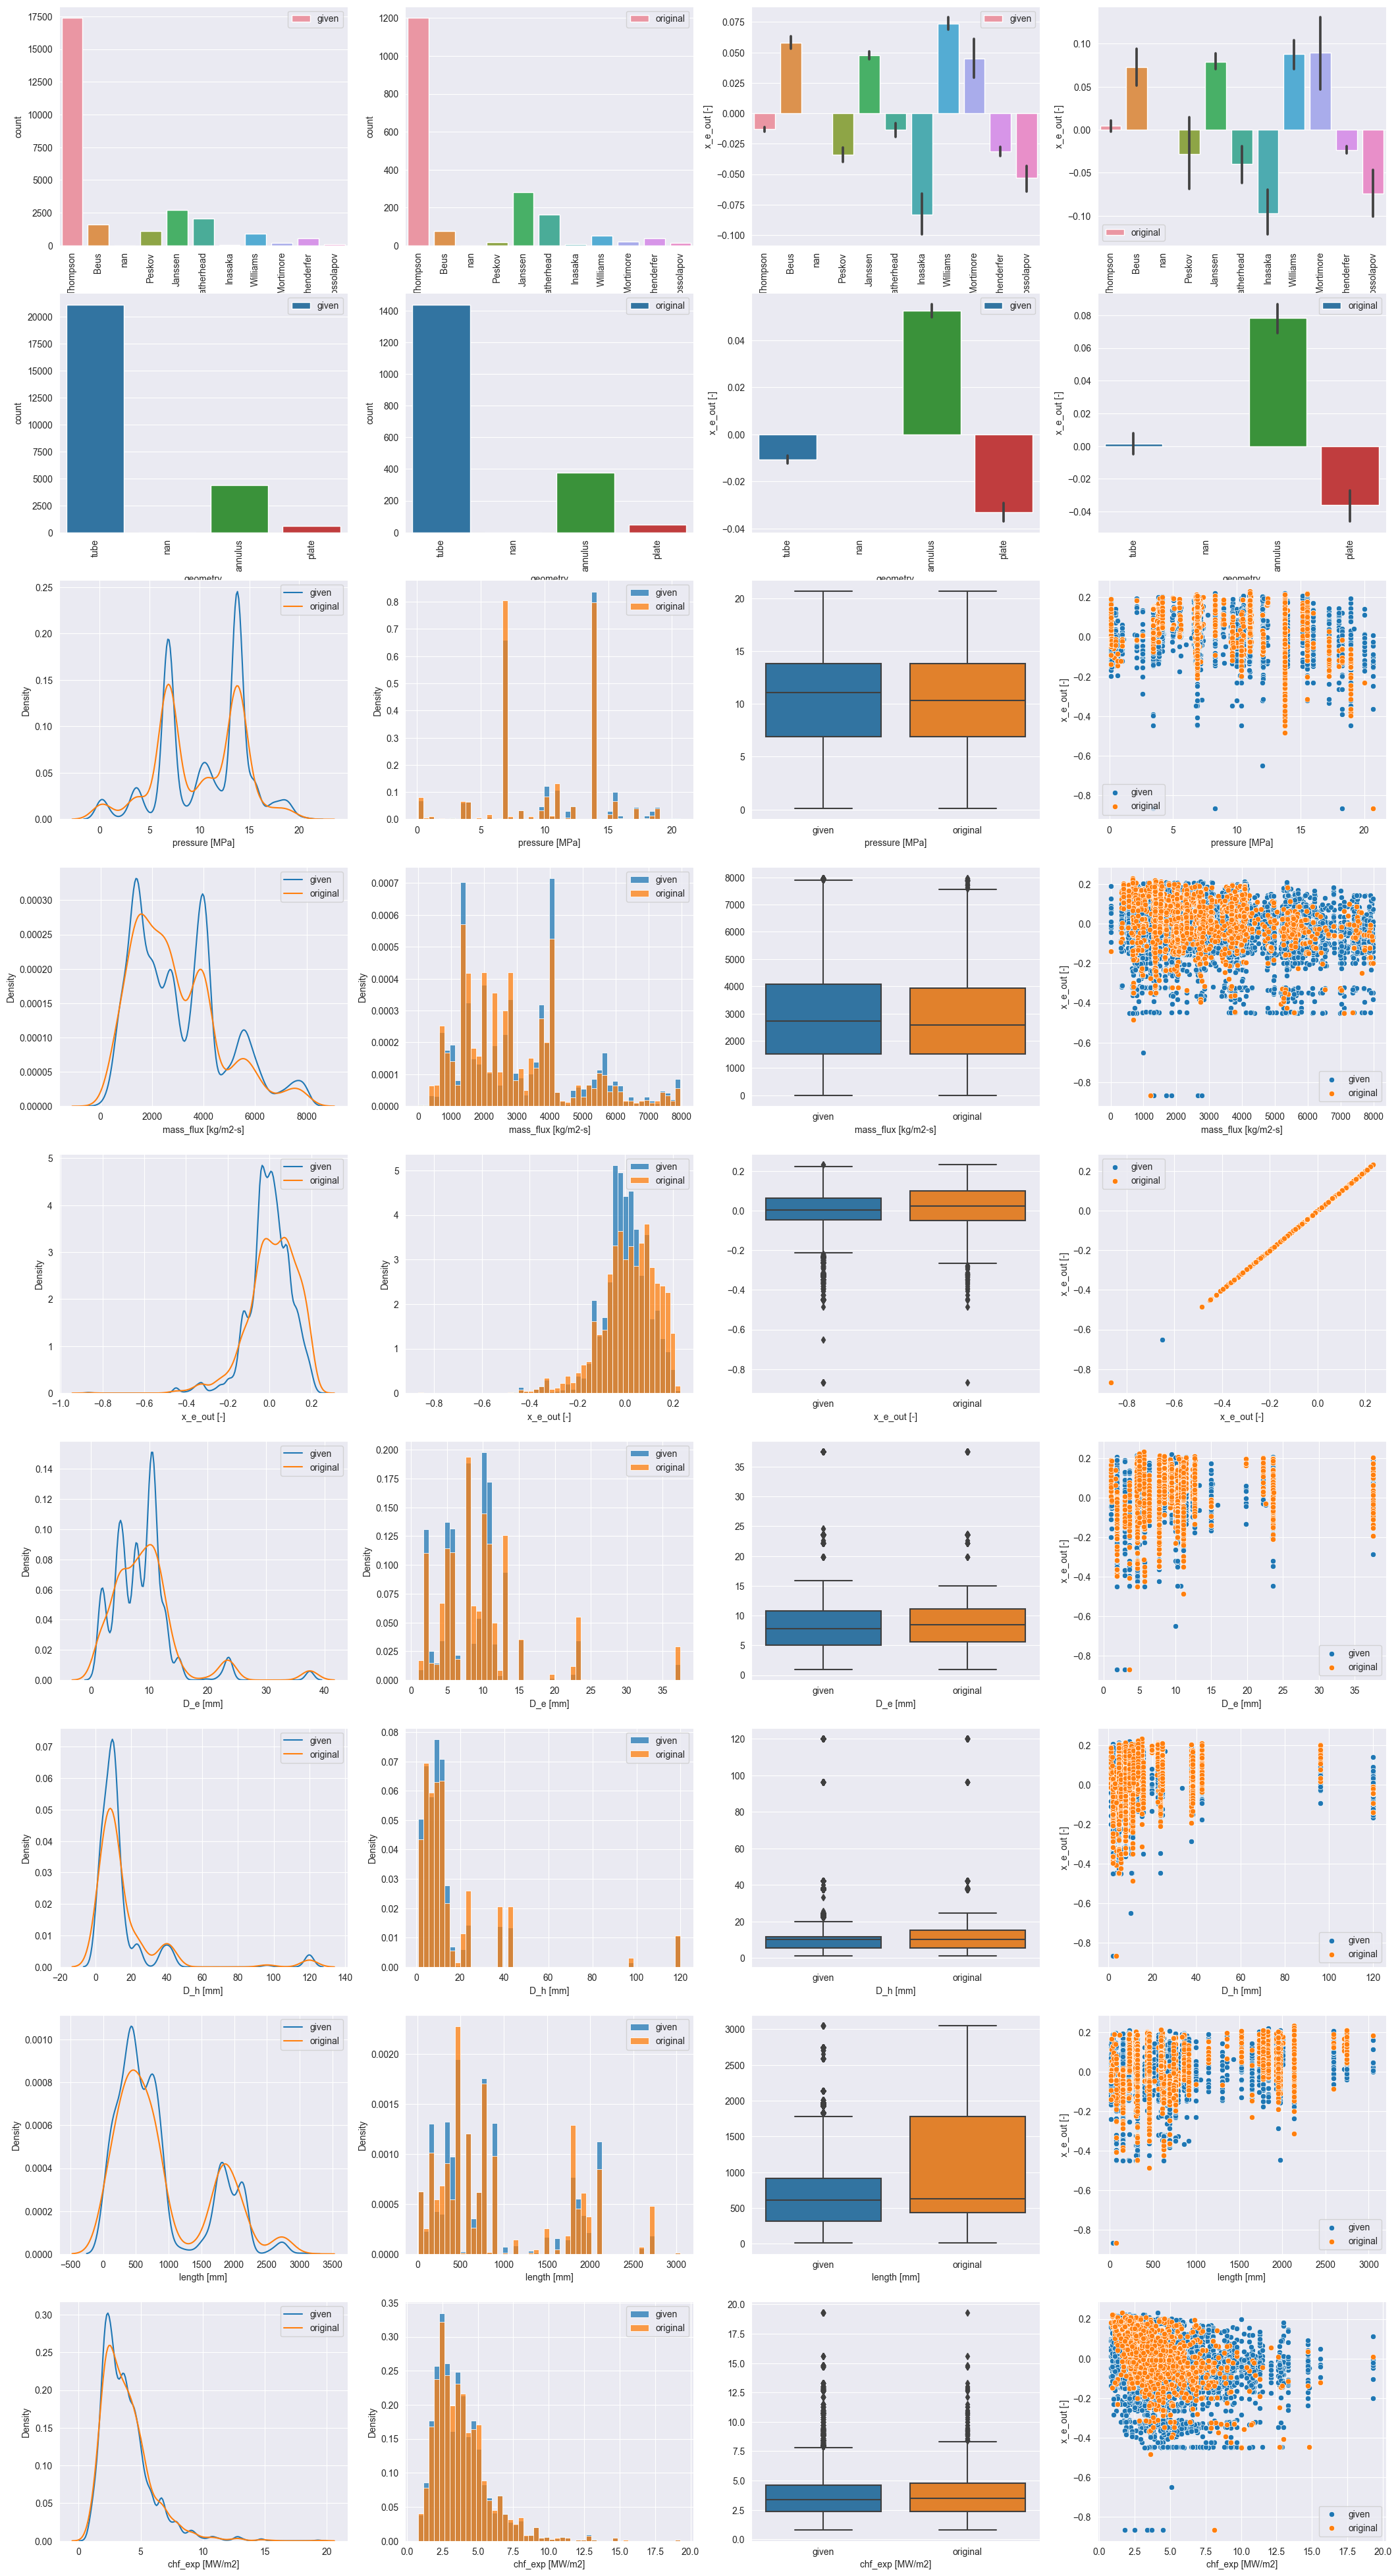

In [9]:
fig, axes = plt.subplots(nrows=len(df_data.columns), ncols=4, figsize=(26, 50))
axes = axes.flatten()

def graph_numerical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Plot densities
    for df, column, label in data:
        sns.kdeplot(df[column], label=label, ax=axes[axes_start_i], fill=False)
    for df, column, label in data:
        sns.histplot(df[column], label=label, ax=axes[axes_start_i + 1], stat="density", bins=50)

    # Plot boxplot
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)
    sns.boxplot(data=df_tmp, ax=axes[axes_start_i + 2])
    axes[axes_start_i + 2].set_xlabel(col)

    # Plot target correlation
    for df, column, label in data:
        sns.scatterplot(x=column, y=target, label=label, ax=axes[axes_start_i + 3], data=df)

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 3].legend()

def graph_categorical_feature(data: list[tuple[pd.DataFrame, str, str]], target: str, axes_start_i: int) -> None:
    # Makes sure that the categories are shown in the same order
    category_order: list[str] = data[0][0][data[0][1]].unique()

    # Plot barplots
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.countplot(x=column, data=df, label=label, order=category_order, ax=axes[axes_start_i + il])
        axes[axes_start_i + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot target correlation
    for il, data_pack in enumerate(data):
        df, column, label = data_pack
        sns.barplot(x=column, y=target, data=df, label=label, order=category_order, ax=axes[axes_start_i + 2 + il])
        axes[axes_start_i + 2 + il].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

    # Plot legends
    axes[axes_start_i].legend()
    axes[axes_start_i + 1].legend()
    axes[axes_start_i + 2].legend()
    axes[axes_start_i + 3].legend()


i = 0
for col in df_data.columns:
    if pd.api.types.is_numeric_dtype(df_data[col]):
        graph_numerical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    else:
        graph_categorical_feature([(df_data, col, 'given'), (df_og, col, 'original')], 'x_e_out [-]', i)
    i += 4

plt.show()

##### The original data closely follows the distribution of our given synthetic data. This suggesting the value where nulled in our given data set evenly across all features, this means that original data should be good to use without introduction feature or distribution bias.

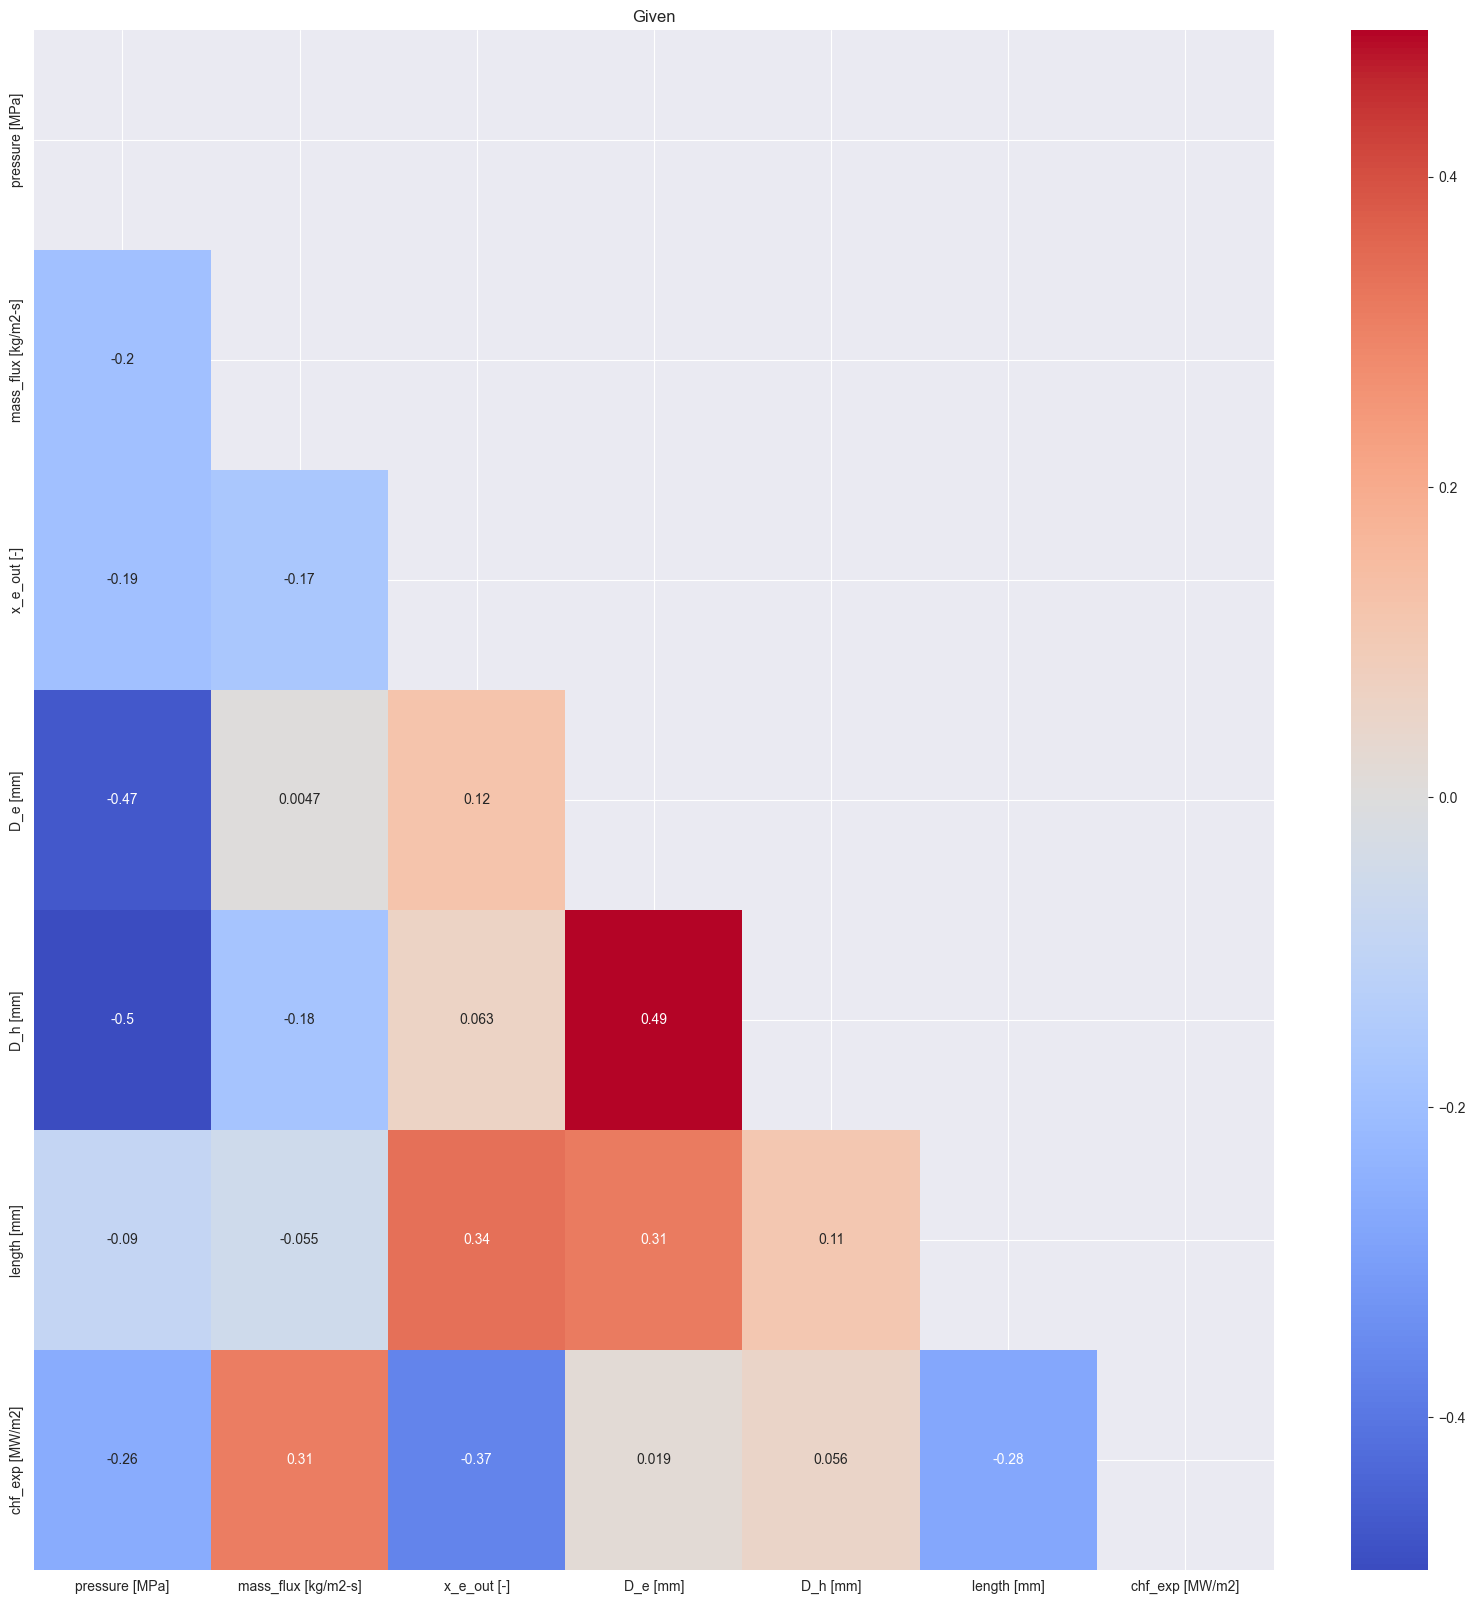

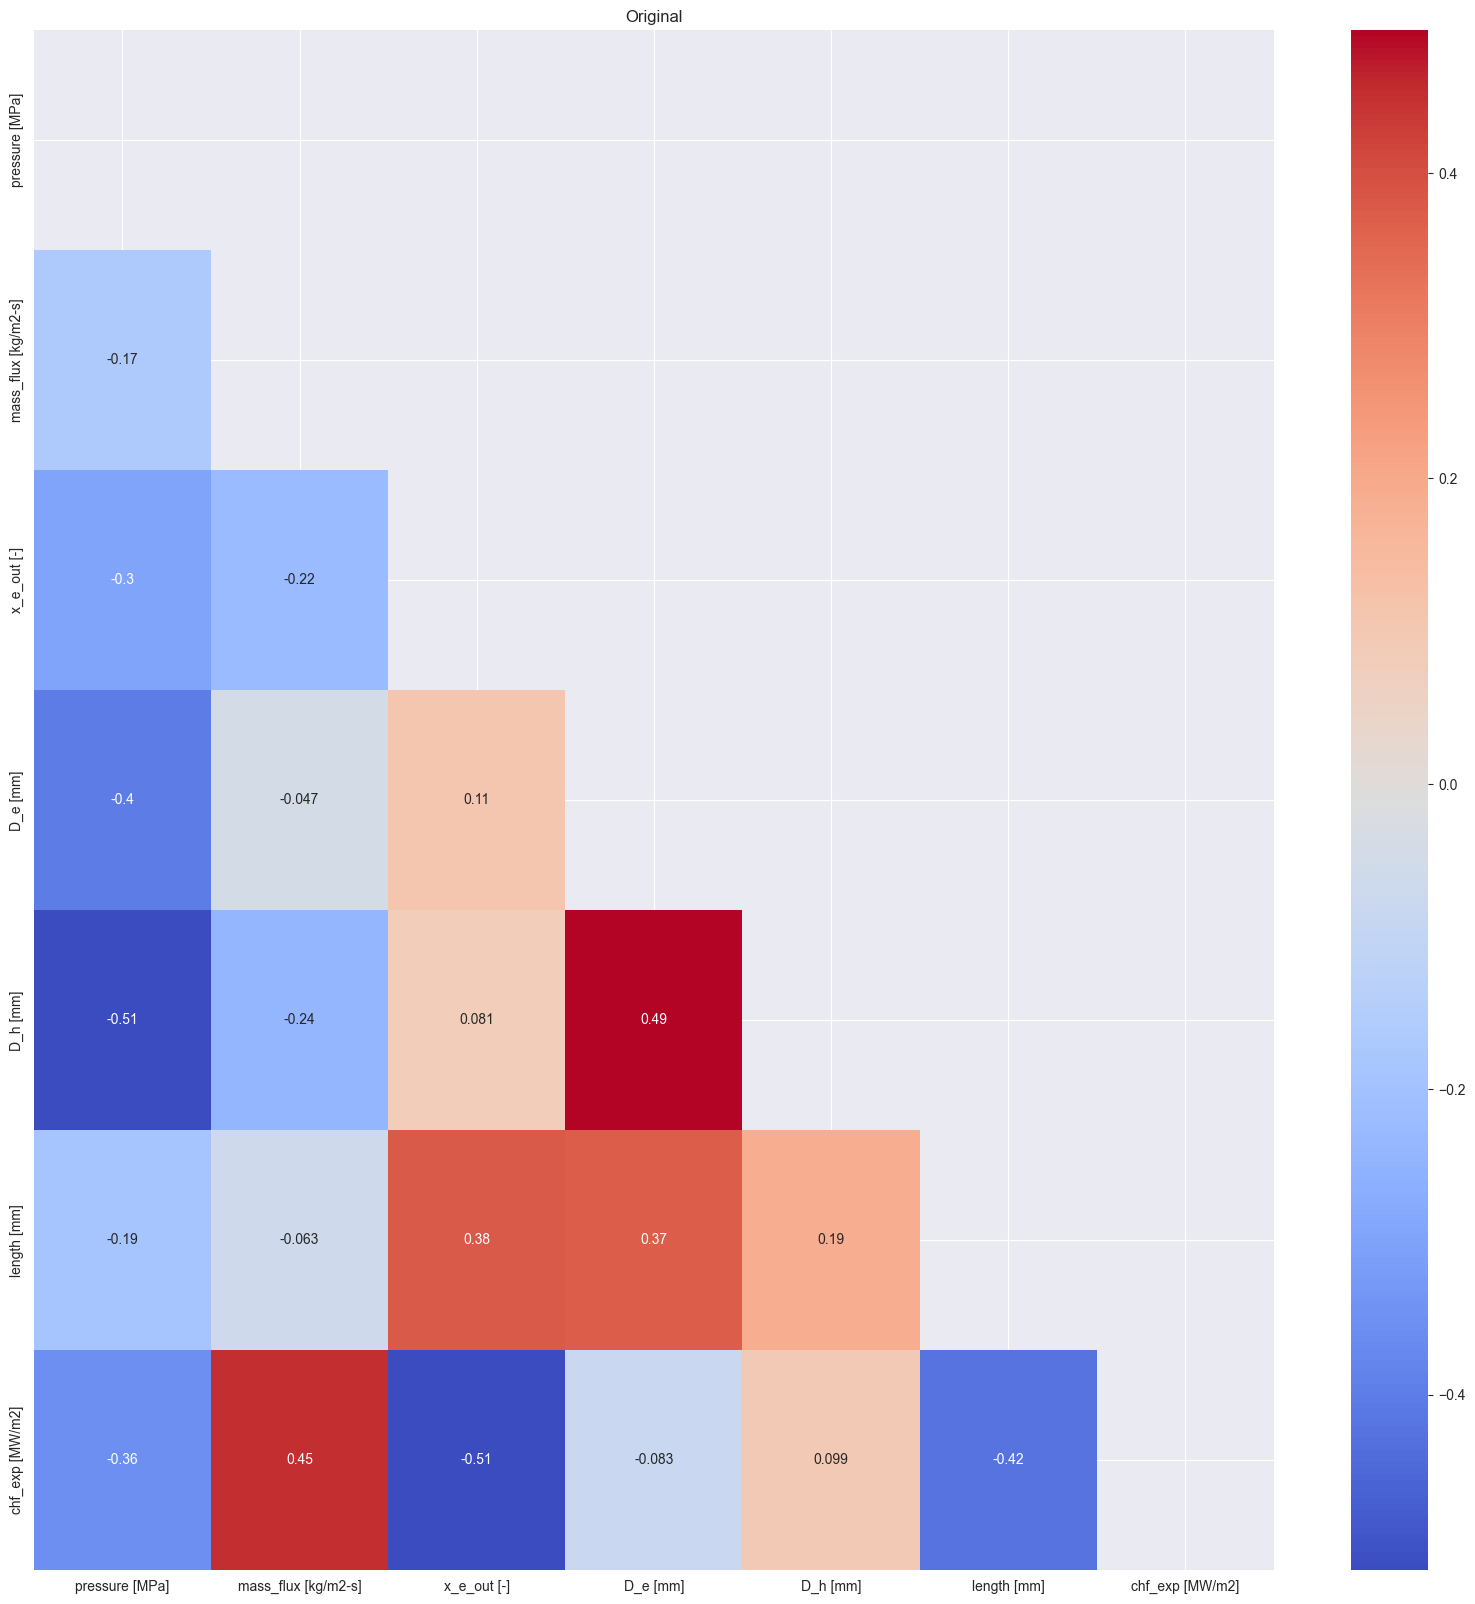

In [10]:
def show_feature_correlation(df: pd.DataFrame, title: str):
    plt.figure(figsize=(20, 20))
    corr_matrix = df.select_dtypes(include='number').corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, mask=mask)
    plt.title(title)
    plt.show()

show_feature_correlation(df_data, "Given")
show_feature_correlation(df_og, "Original")

# Data Prep

In [11]:
numerical_columns = ['pressure [MPa]', 'mass_flux [kg/m2-s]','x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
numerical_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
categorical_columns = ['author', 'geometry']
target = 'x_e_out [-]'

In [12]:
label_encoders = {}

def label_encode(df: pd.DataFrame) -> None:
    for column in categorical_columns:
        label_encoder: LabelEncoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

def reverse_encode(df: pd.DataFrame) -> None:
    for column in label_encoders.keys():
        df[column] = df[column].astype(int)
        df[column] = label_encoders[column].inverse_transform(df[column])

def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

In [13]:
df_train: pd.DataFrame = pd.concat([df_data, df_og])
df_train.reset_index(inplace=True, drop=True)

In [14]:
#label_encode(df_train)

In [15]:
df_train = one_hot_encode(df_train)

In [16]:
df_train

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6,0,0,0,0,0,0,0,1,0,0,0,0,1
1,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2,0,0,0,0,0,0,0,1,0,0,0,0,1
2,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5,0,0,0,0,0,0,0,1,0,0,0,0,0
3,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,13.79,686.0,NaN,11.1,11.1,457.0,2.8,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,1.01,1500.0,-0.0218,15.0,120.0,10.0,9.4,0,0,0,0,0,0,1,0,0,0,0,1,0
33505,1.01,1500.0,-0.0434,15.0,120.0,10.0,10.4,0,0,0,0,0,0,1,0,0,0,0,1,0
33506,1.01,2000.0,-0.0109,15.0,120.0,10.0,10.8,0,0,0,0,0,0,1,0,0,0,0,1,0
33507,1.01,2000.0,-0.0218,15.0,120.0,10.0,10.9,0,0,0,0,0,0,1,0,0,0,0,1,0


# Train

## Baseline 0: Impute all missing numerical value including target using MICE

In [17]:
# Create an instance of imputer
imputer = IterativeSVD()
#imputer = KNN()

# Perform the imputation
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train), columns=df_train.columns)
# Print the imputed DataFrame
print("Imputed DataFrame:")
df_train_imputed

[IterativeSVD] Iter 1: observed MAE=32.927110
[IterativeSVD] Iter 2: observed MAE=1.071935
[IterativeSVD] Iter 3: observed MAE=0.369103
[IterativeSVD] Iter 4: observed MAE=0.051650
Imputed DataFrame:


,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,7.000000,3770.0,0.175400,6.523997,10.8,432.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,13.280695,6049.0,-0.041600,10.300000,10.3,762.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,13.790000,2034.0,0.033500,7.700000,7.7,457.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,13.790000,3679.0,-0.027900,5.600000,15.2,2134.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,13.790000,686.0,-0.010688,11.100000,11.1,457.0,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,1.010000,1500.0,-0.021800,15.000000,120.0,10.0,9.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33505,1.010000,1500.0,-0.043400,15.000000,120.0,10.0,10.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33506,1.010000,2000.0,-0.010900,15.000000,120.0,10.0,10.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33507,1.010000,2000.0,-0.021800,15.000000,120.0,10.0,10.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
df_train_imputed.isna().sum()

pressure [MPa]         0
mass_flux [kg/m2-s]    0
x_e_out [-]            0
D_e [mm]               0
D_h [mm]               0
length [mm]            0
chf_exp [MW/m2]        0
author_Beus            0
author_Inasaka         0
author_Janssen         0
author_Kossolapov      0
author_Mortimore       0
author_Peskov          0
author_Richenderfer    0
author_Thompson        0
author_Weatherhead     0
author_Williams        0
geometry_annulus       0
geometry_plate         0
geometry_tube          0
dtype: int64

## Baseline 1: Tree boosting on imputed data

### Construct new training data

In [19]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[f'{column}_was_an'] = df_train[column].isna().astype(int)

In [20]:
for column in numerical_features:
    if df_train[column].isna().sum() > 0:
        df_train[column] = df_train_imputed[column]

In [21]:
df_test = df_train[df_train[target].isna()]
df_train = df_train[~df_train[target].isna()]

In [22]:
def remove_special_characters(column_name):
    # Remove special characters using regular expressions
    return re.sub(r"[^a-zA-Z0-9_]+", "", column_name)

def remove_special_characters_from_dataframe(df):
    # Remove special characters from all column names in the DataFrame
    df.columns = [remove_special_characters(col) for col in df.columns]
    return df

df_test = remove_special_characters_from_dataframe(df_test)
df_train = remove_special_characters_from_dataframe(df_train)

In [23]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'num_leaves': trial.suggest_int('num_leaves', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'verbosity': -1
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the LGBM regressor
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_lgbm = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_lgbm.best_params
best_mae = study_lgbm.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 16:19:56,750] A new study created in memory with name: no-name-31f16570-9a33-4d43-9300-acf2613bba88
[I 2023-05-17 16:19:57,931] Trial 0 finished with value: 0.051529880135987055 and parameters: {'max_depth': 7, 'num_leaves': 6, 'learning_rate': 0.028897794398644094, 'min_child_samples': 13, 'reg_alpha': 1.3259439846592385, 'reg_lambda': 7.718774062769445, 'force_col_wise': False}. Best is trial 0 with value: 0.051529880135987055.
[I 2023-05-17 16:19:59,113] Trial 1 finished with value: 0.05269216715807174 and parameters: {'max_depth': 5, 'num_leaves': 5, 'learning_rate': 0.023956993010079516, 'min_child_samples': 15, 'reg_alpha': 4.066696720649404, 'reg_lambda': 3.0859273583674165, 'force_col_wise': True}. Best is trial 0 with value: 0.051529880135987055.
[I 2023-05-17 16:20:01,738] Trial 2 finished with value: 0.05128056737092298 and parameters: {'max_depth': 4, 'num_leaves': 5, 'learning_rate': 0.06468670845006304, 'min_child_samples': 14, 'reg_alpha': 0.907442311537879

Best Parameters: {'max_depth': 9, 'num_leaves': 9, 'learning_rate': 0.06808095216267875, 'min_child_samples': 6, 'reg_alpha': 0.9064613757767656, 'reg_lambda': 7.856859358662124, 'force_col_wise': False}
Best MAE: 0.050962807785450114


In [24]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'loss_function': 'MAE',
        'depth': trial.suggest_int('depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'iterations': 1000,
        'early_stopping_rounds': 100,
        'verbose': False
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the CatBoost regressor
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_catboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost.optimize(objective, n_trials=50)

# Print the best parameters and the best MAE
best_params = study_catboost.best_params
best_mae = study_catboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 16:21:53,361] A new study created in memory with name: no-name-147ad369-e5fc-4741-8363-a5472254e7cb
[I 2023-05-17 16:21:59,323] Trial 0 finished with value: 0.05037975535261894 and parameters: {'depth': 5, 'learning_rate': 0.03730393604252277, 'l2_leaf_reg': 9.68982414847938, 'random_strength': 4.574171244885734, 'bagging_temperature': 0.7711528540141461, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.05037975535261894.
[I 2023-05-17 16:22:02,390] Trial 1 finished with value: 0.05149973139219267 and parameters: {'depth': 3, 'learning_rate': 0.03205952000305255, 'l2_leaf_reg': 2.593057161525302, 'random_strength': 4.59900736074757, 'bagging_temperature': 0.5091867029542047, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.05037975535261894.
[I 2023-05-17 16:22:06,682] Trial 2 finished with value: 0.05038912017947323 and parameters: {'depth': 4, 'learning_rate': 0.09447479051386161, 'l2_leaf_reg': 3.962405947745033, 'random_strength': 5.792874631256963

Best Parameters: {'depth': 5, 'learning_rate': 0.06378866989580786, 'l2_leaf_reg': 0.7066841595418207, 'random_strength': 1.4232203887457386, 'bagging_temperature': 0.39788008144618286, 'grow_policy': 'Lossguide'}
Best MAE: 0.050116608616886535


In [25]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'reg:pseudohubererror',
        'eval_metric': 'mae',
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        'grow_policy': 'lossguide',
        'eta': trial.suggest_float('eta', 0.01, 1),
        'early_stopping_rounds': 100,
        'huber_slope': trial.suggest_float('huber_slope', 0.01, 1),
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the XGBoost regressor
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], verbose_eval=False)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(dval)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_xgboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgboost.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_xgboost.best_params
best_mae = study_xgboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 16:25:38,375] A new study created in memory with name: no-name-dcf491fb-824b-470c-ab27-02f7578ad031
[I 2023-05-17 16:25:38,508] Trial 0 finished with value: 0.31865011534299603 and parameters: {'max_depth': 7, 'learning_rate': 0.029220966477068316, 'min_child_weight': 8.461835495794404, 'gamma': 4.632886258807827, 'subsample': 0.5745823845539497, 'colsample_bytree': 0.9672826715465537, 'reg_alpha': 0.065921131081631, 'reg_lambda': 1.8575529691654475, 'eta': 0.23407554630520033, 'huber_slope': 0.5593521107834778}. Best is trial 0 with value: 0.31865011534299603.
[I 2023-05-17 16:25:38,580] Trial 1 finished with value: 0.1707420275424409 and parameters: {'max_depth': 4, 'learning_rate': 0.08661824514957928, 'min_child_weight': 6.565043492349532, 'gamma': 0.23148987362690554, 'subsample': 0.9669781146913764, 'colsample_bytree': 0.5239883951182007, 'reg_alpha': 4.092499356832547, 'reg_lambda': 7.691474188763208, 'eta': 0.29075946671351904, 'huber_slope': 0.7440449911971247}. 

Best Parameters: {'max_depth': 4, 'learning_rate': 0.09203844311669886, 'min_child_weight': 5.827608197481036, 'gamma': 1.896534085894075, 'subsample': 0.8096127665958093, 'colsample_bytree': 0.8832632247753971, 'reg_alpha': 2.9707001031623825, 'reg_lambda': 2.5980606742625305, 'eta': 0.27882584871949145, 'huber_slope': 0.15688969515452475}
Best MAE: 0.07054173509947766


In [26]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': 500,
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    # Split the data into training and validation sets
    X = df_train.drop('x_e_out', axis=1)
    y = df_train['x_e_out']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest regressor
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)

    # Predict on the validation set and calculate MAE
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Create the Optuna study
study_rf = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_rf.optimize(objective, n_trials=100)

# Print the best parameters and the best MAE
best_params = study_rf.best_params
best_mae = study_rf.best_value
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

[I 2023-05-17 16:25:50,267] A new study created in memory with name: no-name-d46bc073-b8a4-4c82-aedf-7ee88b7f463a
[I 2023-05-17 16:25:57,116] Trial 0 finished with value: 0.057690727426529115 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 0 with value: 0.057690727426529115.
[I 2023-05-17 16:25:58,839] Trial 1 finished with value: 0.06232332713185447 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.057690727426529115.
[I 2023-05-17 16:26:01,682] Trial 2 finished with value: 0.05701691505889178 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.05701691505889178.
[I 2023-05-17 16:26:07,703] Trial 3 finished with value: 0.05939999738367176 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': None}. Best is t

Best Parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': None}
Best MAE: 0.05398147871030296


In [27]:
class Pipeline:

    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'LightGBM':
            self.model = lgb.LGBMRegressor(**study_lgbm.best_params)
        elif model_type == 'CatBoost':
            self.model = CatBoostRegressor(**study_catboost.best_params)
        elif model_type == 'XGBoost':
            self.model = xgb.XGBRegressor(**study_xgboost.best_params)
        elif model_type == 'RandomForest':
            self.model = RandomForestRegressor(**study_rf.best_params)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        if self.model_type in ['RandomForest']:
            self.model.fit(X, y.ravel())
        else:
            self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

In [28]:
def train(model_type):
    X = df_train.drop(['x_e_out'], axis=1)
    y = df_train['x_e_out']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('x_e_out', axis=1)
        y_train = train_dataframe['x_e_out']
        X_dev = dev_dataframe.drop('x_e_out', axis=1)
        y_dev = dev_dataframe['x_e_out']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [29]:
supported_models = ['LightGBM', 'CatBoost', 'XGBoost', 'RandomForest']

In [30]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


-------------------- LightGBM -------------------- 
Fold 0 loss: 0.0522403458792702
Fold 1 loss: 0.05457518384648191
Fold 2 loss: 0.05209027786221528


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 0.052522129700922404
Fold 4 loss: 0.0532193676579202
Mean loss: 0.052929460989362
-------------------- CatBoost -------------------- 


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 loss: 0.05088818709058861
Fold 1 loss: 0.05258641920646621
Fold 2 loss: 0.05011860490482967
Fold 3 loss: 0.05026451334704096
Fold 4 loss: 0.051328744337681254
Mean loss: 0.05103729377732134
-------------------- XGBoost -------------------- 
Fold 0 loss: 0.05898346384090183
Fold 1 loss: 0.059690559197203244
Fold 2 loss: 0.058542453666553175
Fold 3 loss: 0.05930933810625361
Fold 4 loss: 0.05953381941993562
Mean loss: 0.059211926846169494
-------------------- RandomForest -------------------- 
Fold 0 loss: 0.053048953163429544
Fold 1 loss: 0.05506339416987699
Fold 2 loss: 0.053272982238710284
Fold 3 loss: 0.05318054401255508
Fold 4 loss: 0.053704125240747004
Mean loss: 0.053653999765063784


## Calculate assembly weights

In [31]:
model_predictions_on_validation = {'model_name': [], 'x': [], 'y': []}
def calc_model_predictions_on_validation(pipelines, eval_sets_idx):
    predictions = None
    ground_truth = None

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        if predictions is None:
            predictions = np.array(prediction).flatten()
            ground_truth = np.array(y_dev).flatten()
        else:
            predictions = np.concatenate((predictions,  np.array(prediction).flatten()))
            ground_truth = np.concatenate((ground_truth,  np.array(y_dev).flatten()))

    model_predictions_on_validation['model_name'].append(model_name)
    model_predictions_on_validation['x'].append(predictions)
    model_predictions_on_validation['y'].append(ground_truth) # Should be the same for all models

for model_name in supported_models:
    calc_model_predictions_on_validation(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets'])

In [32]:
def eval_assembly_on_validation(weights):
    #weights = weights / np.sum(weights, axis=0, keepdims=True)
    prediction = 0

    for model_id, x in enumerate(model_predictions_on_validation['x']):
        prediction += x * weights[model_id]

    return mean_absolute_error(model_predictions_on_validation['y'][0], prediction)

In [33]:
# Set initial weights
model_weights = np.array([0.25, 0.25, 0.25, 0.25])
# Define the optimization bounds
bounds = [(0, 0.5)] * len(model_weights)

# Define the optimization function
res = minimize(eval_assembly_on_validation, model_weights, method='nelder-mead', bounds=bounds)
# Print the optimized weights
optimal_model_weights = res.x
print(optimal_model_weights.sum())
#optimal_model_weights = optimal_model_weights / np.sum(optimal_model_weights, axis=0, keepdims=True)
print(optimal_model_weights.sum())

0.9453874363537713
0.9453874363537713


In [34]:
df_optimal_model_weights = {'model_name': [], 'weight': []}
for i in range(len(model_predictions_on_validation['model_name'])):
    df_optimal_model_weights['model_name'].append(model_predictions_on_validation['model_name'][i])
    df_optimal_model_weights['weight'].append(optimal_model_weights[i])
    print(f"{optimal_model_weights[i]:.3f} {model_predictions_on_validation['model_name'][i]}")
df_optimal_model_weights = pd.DataFrame(df_optimal_model_weights)

0.263 LightGBM
0.500 CatBoost
0.000 XGBoost
0.182 RandomForest


In [35]:
performance_data = {'model_name': [], 'training_loss': [], 'og_data_excluded': []}
def get_loss(pipelines, eval_sets_idx):
    losses = []

    for pipeline, eval_set in zip(pipelines, eval_sets_idx):
        dev = df_train.iloc[eval_set[eval_set < 15281]]
        X_dev = dev.drop('x_e_out', axis=1)
        y_dev = dev['x_e_out']
        prediction = pipeline.predict(X_dev)

        loss = mean_absolute_error(y_dev, prediction)
        losses.append(loss)

    return np.array(losses).mean()

for model_name in supported_models:
    performance_data['model_name'].append(model_name)
    performance_data['training_loss'].append(np.array(train_results[f'{model_name}_losses']).mean())
    performance_data['og_data_excluded'].append(get_loss(train_results[f'{model_name}_pipelines'], train_results[f'{model_name}_eval_sets']))
performance_data = pd.DataFrame(performance_data)

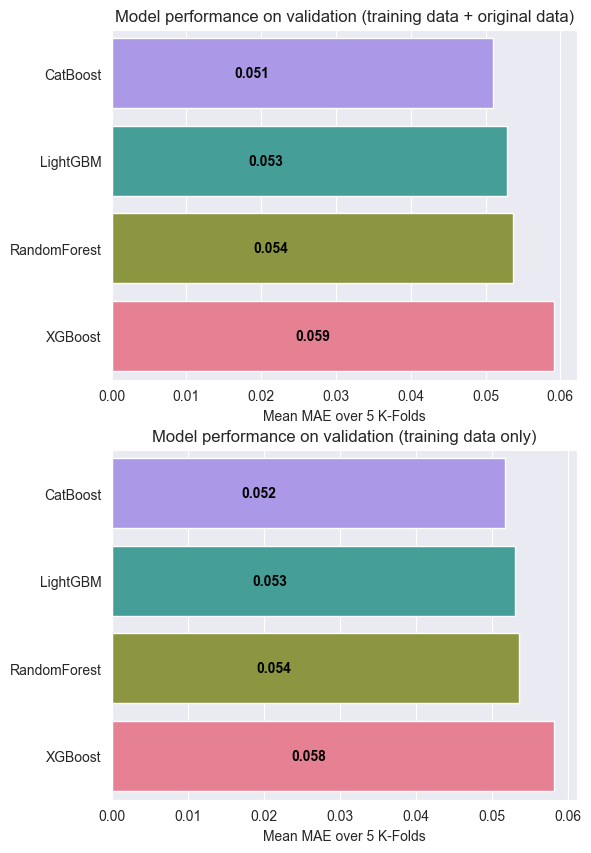

In [36]:
loss_eval_types: list[str] = ['training_loss', 'og_data_excluded']
fig, axes = plt.subplots(nrows=len(loss_eval_types), ncols=1, figsize=(6, 10))
axes = axes.flatten()

palette = sns.color_palette("husl", n_colors=len(performance_data))
palette_reversed = palette[::-1]
titles = ['Model performance on validation (training data + original data)',
          'Model performance on validation (training data only)']

for ax_index, loss_eval_type in enumerate(loss_eval_types):
    performance_data.sort_values(loss_eval_type, ascending=True, inplace=True)
    sns.barplot(x=loss_eval_type, y='model_name', data=performance_data, ax=axes[ax_index], palette=palette_reversed)
    for i, v in enumerate(performance_data[loss_eval_type]):
        axes[ax_index].text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
    axes[ax_index].set(ylabel=None)
    axes[ax_index].set(xlabel="Mean MAE over 5 K-Folds")
    axes[ax_index].set_title(titles[ax_index])
plt.show()

In [37]:
performance_data

,model_name,training_loss,og_data_excluded
1,CatBoost,0.051037,0.051694
0,LightGBM,0.052929,0.053025
3,RandomForest,0.053654,0.053570
2,XGBoost,0.059212,0.058199


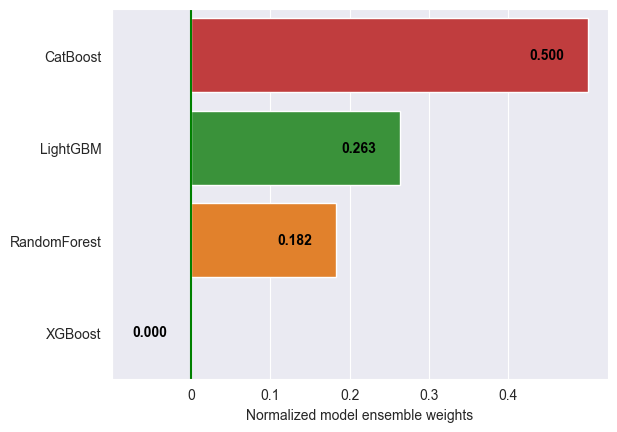

In [38]:
df_optimal_model_weights.sort_values('weight', ascending=True, inplace=True)
ax = sns.barplot(x='weight', y='model_name', data=df_optimal_model_weights)
ax.set_ylim(ax.get_ylim()[::-1])
for i, v in enumerate(df_optimal_model_weights['weight']):
    ax.text(v - 0.03, i, '{:.3f}'.format(v), color='black', fontweight='bold', ha='right', va='center')
ax.set(ylabel=None)
ax.set(xlabel="Normalized model ensemble weights")
ax.set_xlim([-0.1, None])
ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4])
ax.set_xticklabels(['', 0, 0.1, 0.2, 0.3, 0.4])
plt.axvline(x=0, color='g', linestyle='-')
plt.show()

# Feature Importance

In [39]:
def make_predictions(x):
    prediction = 0

    for model_id in range(len(supported_models)):
        for pipeline in train_results[f'{supported_models[model_id]}_pipelines']:
            prediction += np.array(pipeline.predict(x)).flatten() * optimal_model_weights[model_id] * 0.2

    return prediction

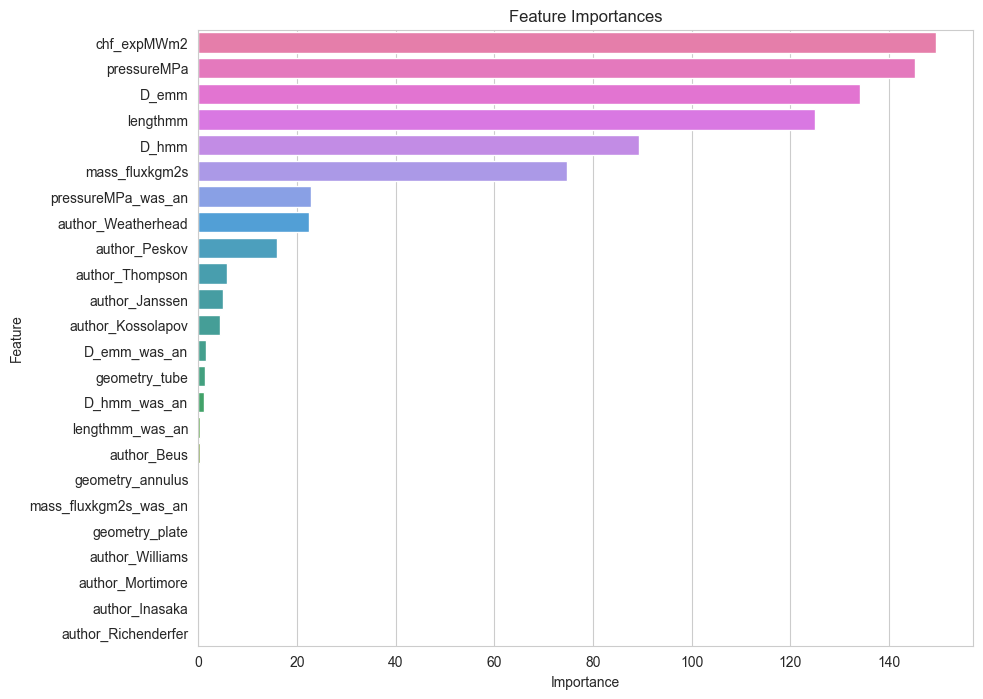

In [40]:
# Get feature importance
importance = train_results['LightGBM_pipelines'][0].model.feature_importances_
for i in range(1, len(train_results['LightGBM_pipelines'])):
    importance += train_results['LightGBM_pipelines'][i].model.feature_importances_
importance = importance / 5.0
feature_names = df_train.drop('x_e_out', axis=1).columns.values

# Create a dataframe of feature importance
df_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
# Sort features by importance
df_importance = df_importance.sort_values('importance', ascending=False)

# Create horizontal bar plot of feature importance
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))
palette = sns.color_palette("husl", len(df_importance))
palette.reverse()
sns.barplot(x="importance", y="feature", data=df_importance, palette=palette)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [41]:
def get_split_data(eval_sets_idx) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_all_data: pd.DataFrame = None
    for eval_set in eval_sets_idx:
        if df_all_data is None:
            df_all_data = df_train.iloc[eval_set]
        else:
            df_all_data = pd.concat([df_all_data, df_train.iloc[eval_set]])

    df_eval_given: pd.DataFrame = df_all_data[df_all_data.index < len(df_data)]
    df_eval_original: pd.DataFrame = df_all_data[df_all_data.index >= len(df_data)]

    return df_eval_given, df_eval_original

In [42]:
def graph_predictions_vs_true() -> None:
    # All model should have the exact same eval sets
    df_eval_given, df_eval_original = get_split_data(train_results['LightGBM_eval_sets'])

    graph_data = {
        "data": [df_eval_given, df_eval_original],
        "name": ['given', 'original']
    }

    for data, name in zip(graph_data['data'], graph_data['name']):
        X = data.drop('x_e_out', axis=1)
        y = data['x_e_out']
        y_predicted = make_predictions(X)
        data_to_graph = pd.DataFrame({"Predicted": y_predicted, "True": y})
        sns.scatterplot(x='Predicted', y='True', label=f"Belong to {name}", data=data_to_graph)

    plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls='--', c='red')
    plt.title("True vs Predicted")
    plt.legend()

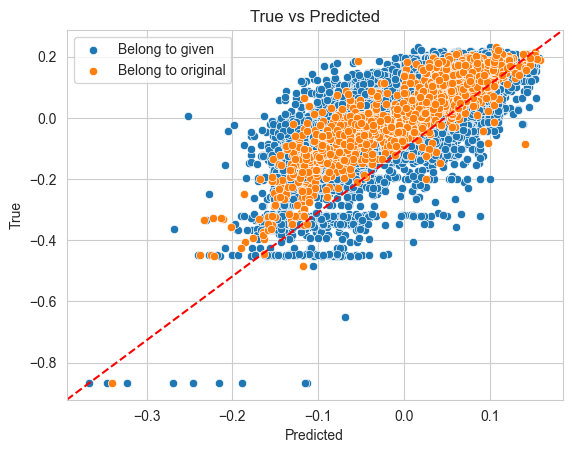

In [43]:
graph_predictions_vs_true()

# Make predictions

In [44]:
df_test = df_test.drop('x_e_out', axis=1)

In [45]:
predictions = make_predictions(df_test)

In [46]:
df_test['x_e_out [-]'] = predictions

In [47]:
df_test['x_e_out [-]'].to_csv("submission.csv", index=True, index_label='id')